In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import os
import time
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("X_train.csv")
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [3]:
test=pd.read_csv("X_test.csv")
test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [4]:
sample_submission=pd.read_csv("sample_submission.csv")
sample_submission.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [5]:
test_id=sample_submission['series_id']
y_train=pd.read_csv("y_train.csv")
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


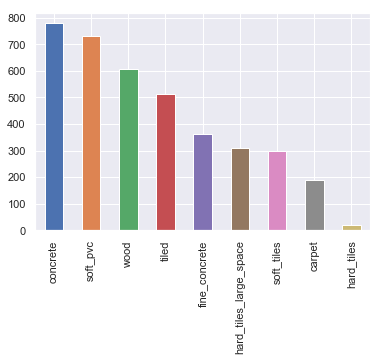

In [6]:
y_train['surface'].value_counts().plot.bar();

In [7]:
train.shape,test.shape,y_train.shape

((487680, 13), (488448, 13), (3810, 3))

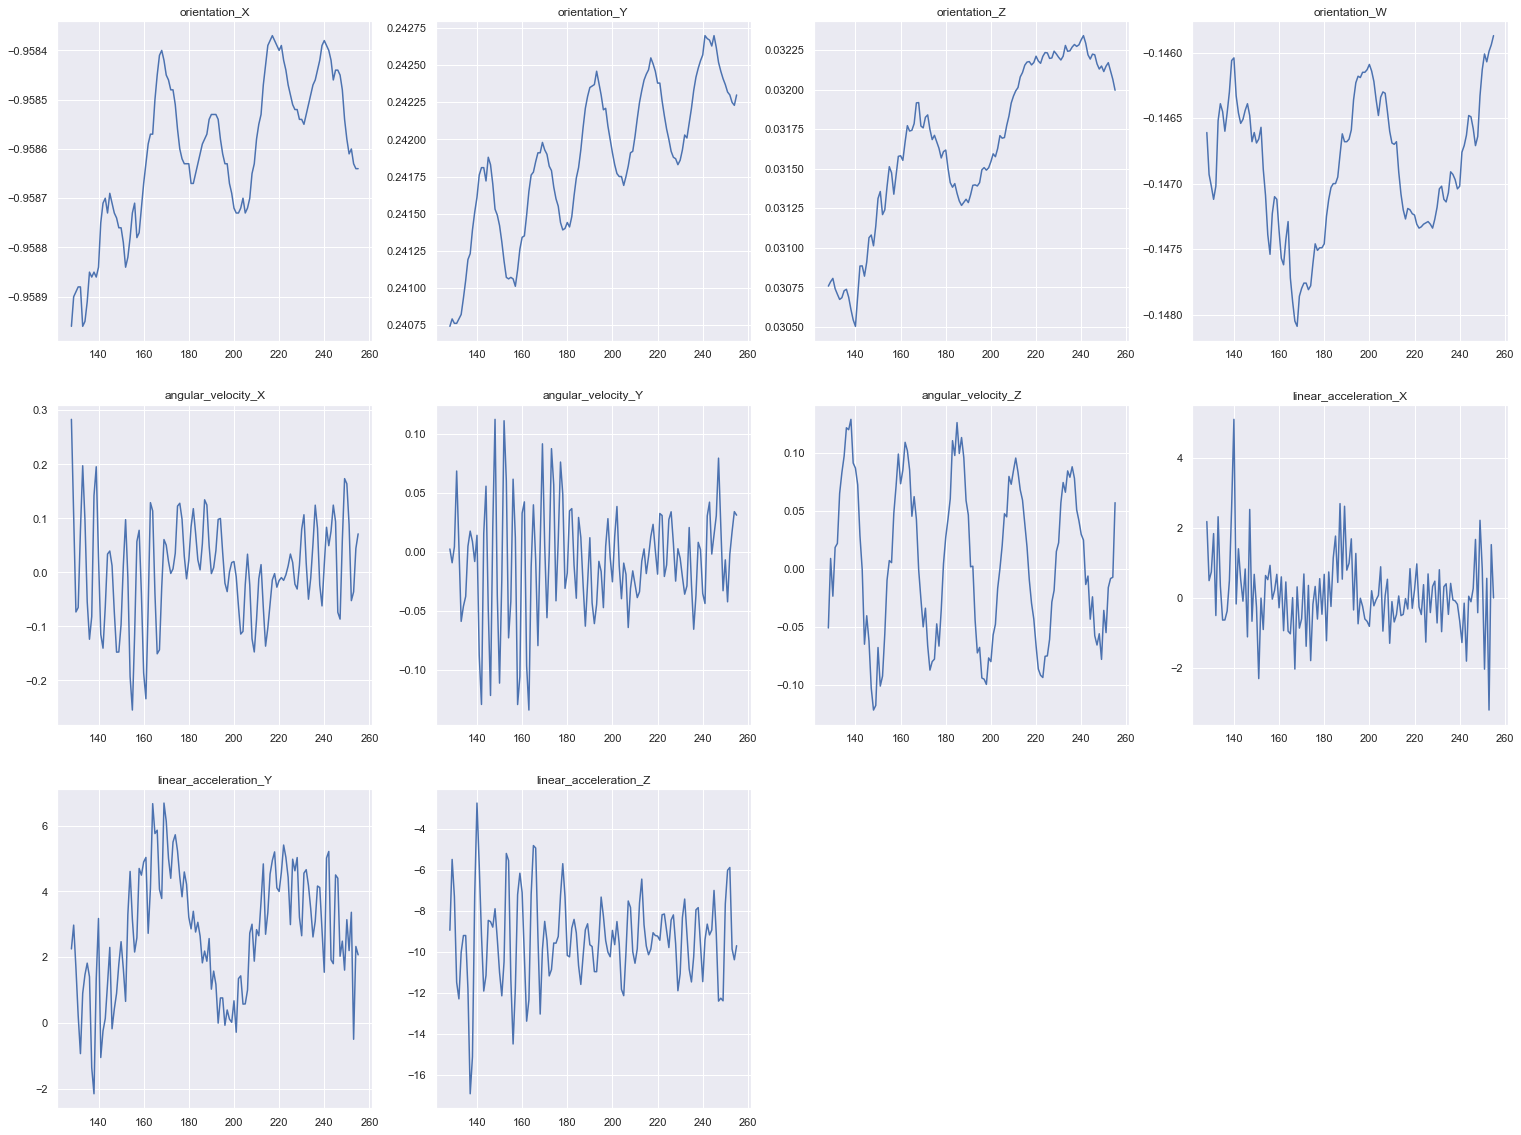

In [8]:
plt.figure(figsize=(26, 20))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 1, col])
    plt.title(col)

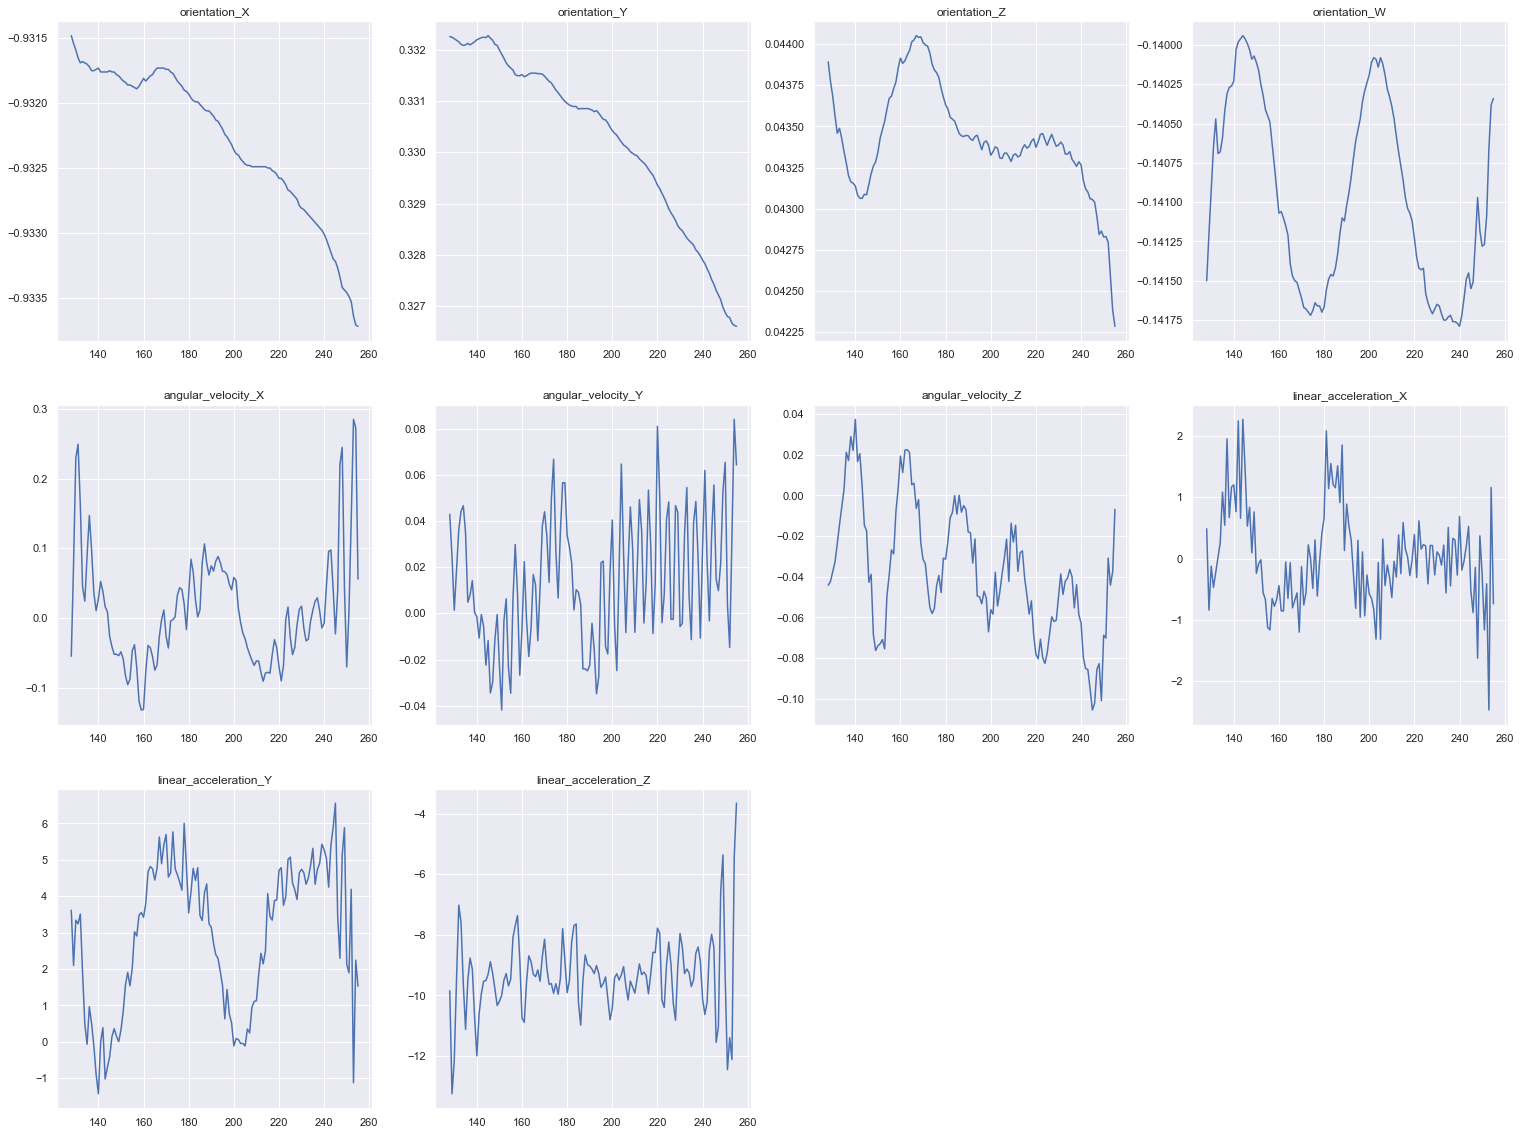

In [9]:
plt.figure(figsize=(26, 20))
for i, col in enumerate(test.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(test.loc[test['series_id'] == 1, col])
    plt.title(col)

## Feature engineering

In [10]:
# refrence from https://www.kaggle.com/jsaguiar/surface-recognition-baseline
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Y']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
    return frame

In [11]:
train_df = feature_extraction(train)
test_df = feature_extraction(test)
train_df.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,...,linear_acceleration_max_to_min,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,...,-440.912422,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,...,-2.994224,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,...,-4.462653,1.855546,12.92295,0.049577,0.405777,4.445092,-0.336429,-13.212587,0.111821,4.445092
3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,0.000026,0.93968,0.310140,0.000453,0.31147,...,-1.675275,3.938777,23.71235,-0.007084,0.202459,0.536344,-1.437307,-0.373159,0.086081,1.437307
4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,0.000080,0.89689,0.428144,0.006165,0.43740,...,16.236353,0.645448,9.82879,-0.021466,0.026864,0.011489,-0.166277,-0.069095,0.007255,0.166277


In [12]:
train_df.shape,test_df.shape

((3810, 91), (3816, 91))

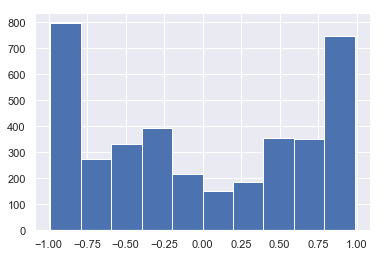

In [13]:
train_df["orientation_X_mean"].hist()

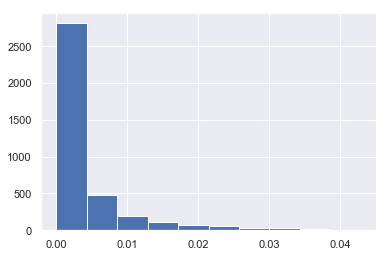

In [14]:
train_df["orientation_X_std"].hist()

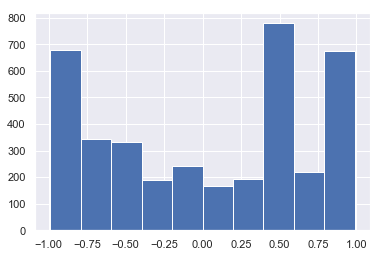

In [15]:
test_df["orientation_X_mean"].hist()

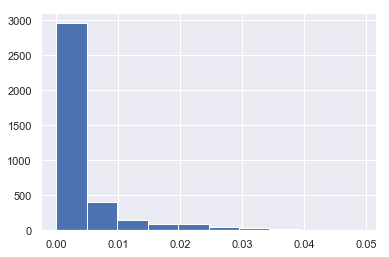

In [16]:
test_df["orientation_X_std"].hist()

In [17]:
le = LabelEncoder()
target_train = le.fit_transform(y_train['surface'])

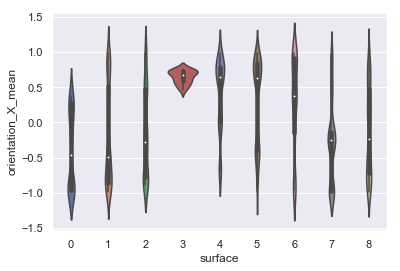

In [18]:
train_df['surface']=target_train
sns.violinplot(data=train_df,x="surface", y="orientation_X_mean")

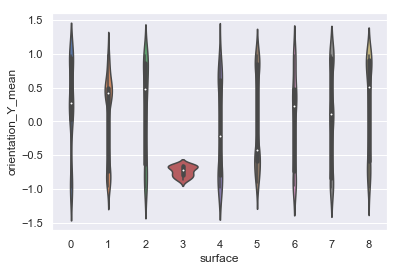

In [19]:
sns.violinplot(data=train_df,x="surface", y="orientation_Y_mean")

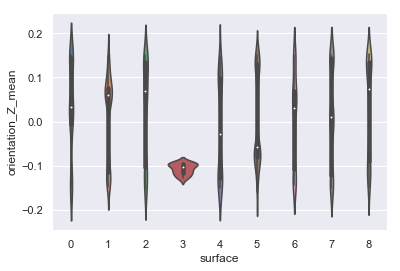

In [20]:
sns.violinplot(data=train_df,x="surface", y="orientation_Z_mean")

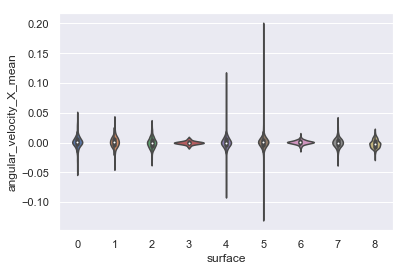

In [21]:
sns.violinplot(data=train_df,x="surface", y="angular_velocity_X_mean")

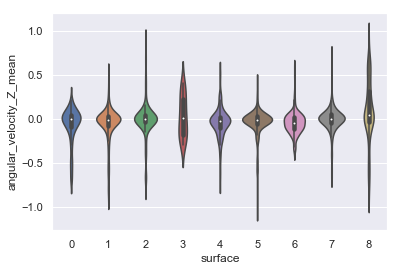

In [22]:
sns.violinplot(data=train_df,x="surface", y="angular_velocity_Z_mean")

In [23]:
train_df=train_df.drop(['surface'],axis=1)

## first We are going to split the data and then we will see how the different models works..

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df, target_train, random_state = 0)
X_train.shape,X_test.shape

((2857, 91), (953, 91))

In [25]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [26]:
preds = []
K = 12
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

## RandomForestClassifier with k-fold

In [27]:
alg =  RandomForestClassifier()

In [28]:
for train_index, test_index in kf.split(X_train):
    train_X, valid_X = X_train[train_index], X_train[test_index]
    train_y, valid_y = Y_train[train_index], Y_train[test_index]
    alg.fit( train_X,  train_y)                   
    pred = alg.predict(X_test)
    preds.append(list(pred))

In [29]:
predx=[]
for i in range(len(preds[0])):
    sum=[]
    for j in range(K):
        sum.append(preds[j][i])
            
    predx.append(max(set(sum), key =sum.count))

In [30]:
accuracy_score(Y_test, predx)

0.8593913955928646

## confusion_matrix

In [31]:
cm = confusion_matrix(Y_test, predx)
cm 

array([[ 38,   7,   0,   0,   1,   1,   2,   1,   2],
       [  3, 162,   2,   0,   2,   3,   3,   2,   3],
       [  0,   7,  64,   0,   1,   4,   3,   2,   5],
       [  0,   0,   0,   5,   0,   0,   0,   0,   2],
       [  1,   3,   1,   0,  69,   1,   1,   0,   1],
       [  0,  10,   0,   0,   1, 177,   2,   0,   3],
       [  1,   3,   0,   0,   0,   2,  68,   0,   1],
       [  2,   6,   1,   0,   2,   1,   1, 112,   4],
       [  1,  12,   4,   0,   0,   8,   0,   5, 124]], dtype=int64)

# LightGBM

In [44]:
params = {
    'num_leaves': 20,
    'min_data_in_leaf': 15,
    'objective': 'multiclass',
    'max_depth': 8,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(X_train, label=Y_train)
eval_hist = lgb.cv(params, train_set, nfold=8, num_boost_round=1200,
                   early_stopping_rounds=80, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(X_test, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 396.3s


In [45]:
predictions

array([[1.02231618e-03, 3.37143301e-03, 5.46622640e-03, ...,
        7.46032948e-04, 5.55054462e-03, 5.26215507e-03],
       [9.87289580e-01, 9.80948373e-04, 1.41763012e-03, ...,
        1.53894385e-04, 9.99711060e-04, 5.81869740e-03],
       [1.61035199e-03, 8.21248300e-01, 2.28351004e-02, ...,
        1.72282911e-03, 3.70518568e-02, 1.80492961e-02],
       ...,
       [2.37110385e-04, 2.18163998e-03, 9.46985982e-04, ...,
        9.76255613e-01, 8.76892909e-03, 3.02535095e-03],
       [1.93792383e-03, 8.51572626e-01, 7.82505898e-02, ...,
        1.88459383e-03, 2.75761684e-02, 1.00209551e-02],
       [7.73567340e-04, 9.80969833e-01, 4.50480465e-03, ...,
        4.04123401e-04, 1.82932423e-03, 2.85453871e-03]])

In [46]:
idx = predictions.argmax(axis=1)
y_pred1 = (idx[:,None] == np.arange(predictions.shape[1])).astype(int)
y_pred1

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [47]:
y_pred1 = [np.where(r == 1)[0][0] for r in y_pred1]

## accuracy_score

In [48]:
accuracy_score(Y_test, y_pred1)

0.8856243441762854

## confusion_matrix

In [41]:
cm = confusion_matrix(Y_test, y_pred1)
cm 

array([[ 38,  10,   0,   0,   1,   0,   0,   1,   2],
       [  1, 163,   1,   0,   2,   1,   3,   4,   5],
       [  0,   6,  63,   0,   2,   4,   1,   2,   8],
       [  0,   0,   0,   5,   0,   0,   0,   0,   2],
       [  0,   2,   4,   0,  70,   1,   0,   0,   0],
       [  0,   5,   0,   0,   2, 182,   0,   0,   4],
       [  0,   3,   0,   0,   0,   1,  71,   0,   0],
       [  1,   3,   0,   0,   1,   1,   1, 120,   2],
       [  0,   9,   5,   0,   0,   5,   0,   3, 132]], dtype=int64)

## Deep Learning with k-fold

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD

## Transform Y_train into onehot encoded form

In [74]:
Y_traind = np.zeros((2857, 9))
Y_traind[np.arange(2857), Y_train] = 1
Y_traind

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [75]:
predsd = []
K = 3
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [76]:
for train_index, test_index in kf.split(X_train):
    train_X, valid_X = X_train[train_index], X_train[test_index]
    train_y, valid_y = Y_train[train_index], Y_train[test_index]
    classifier = Sequential()
    classifier.add(Dense(output_dim = 100, init = 'uniform', activation = 'relu', input_dim = 91))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(output_dim = 60, init = 'uniform', activation = 'relu'))
    classifier.add(Dropout(0.1))
    classifier.add(Dense(output_dim = 40, init = 'uniform', activation = 'relu'))
    classifier.add(Dense(output_dim = 9, init = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.fit(X_train,Y_traind, nb_epoch = 130)
    pred = classifier.predict(X_test)
    predsd.append(list(pred))

Epoch 1/130
2857/2857 [==============================] - 1s 498us/step - loss: 1.9054 - acc: 0.3462
Epoch 2/130
2857/2857 [==============================] - 0s 68us/step - loss: 1.5695 - acc: 0.4001
Epoch 3/130
2857/2857 [==============================] - 0s 68us/step - loss: 1.4356 - acc: 0.4529
Epoch 4/130
2857/2857 [==============================] - 0s 68us/step - loss: 1.3169 - acc: 0.4995
Epoch 5/130
2857/2857 [==============================] - 0s 67us/step - loss: 1.2319 - acc: 0.5397
Epoch 6/130
2857/2857 [==============================] - 0s 63us/step - loss: 1.1730 - acc: 0.5670
Epoch 7/130
2857/2857 [==============================] - 0s 64us/step - loss: 1.1052 - acc: 0.6087
Epoch 8/130
2857/2857 [==============================] - 0s 68us/step - loss: 1.0468 - acc: 0.6258
Epoch 9/130
2857/2857 [==============================] - 0s 62us/step - loss: 1.0256 - acc: 0.6391
Epoch 10/130
2857/2857 [==============================] - 0s 62us/step - loss: 0.9598 - acc: 0.6601
Epoch 11

Epoch 83/130
2857/2857 [==============================] - 0s 64us/step - loss: 0.2805 - acc: 0.9006
Epoch 84/130
2857/2857 [==============================] - 0s 61us/step - loss: 0.2670 - acc: 0.9065
Epoch 85/130
2857/2857 [==============================] - 0s 55us/step - loss: 0.2724 - acc: 0.9044
Epoch 86/130
2857/2857 [==============================] - 0s 55us/step - loss: 0.2634 - acc: 0.9044
Epoch 87/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.2445 - acc: 0.9146
Epoch 88/130
2857/2857 [==============================] - 0s 55us/step - loss: 0.2472 - acc: 0.9100
Epoch 89/130
2857/2857 [==============================] - 0s 55us/step - loss: 0.2451 - acc: 0.9118
Epoch 90/130
2857/2857 [==============================] - 0s 59us/step - loss: 0.2385 - acc: 0.9139
Epoch 91/130
2857/2857 [==============================] - 0s 59us/step - loss: 0.2540 - acc: 0.9114
Epoch 92/130
2857/2857 [==============================] - 0s 56us/step - loss: 0.2905 - acc: 0.8992


2857/2857 [==============================] - 0s 55us/step - loss: 0.5170 - acc: 0.8110
Epoch 35/130
2857/2857 [==============================] - 0s 58us/step - loss: 0.5011 - acc: 0.8190
Epoch 36/130
2857/2857 [==============================] - 0s 58us/step - loss: 0.5019 - acc: 0.8194
Epoch 37/130
2857/2857 [==============================] - 0s 65us/step - loss: 0.4968 - acc: 0.8253
Epoch 38/130
2857/2857 [==============================] - 0s 56us/step - loss: 0.5052 - acc: 0.8155
Epoch 39/130
2857/2857 [==============================] - 0s 57us/step - loss: 0.4726 - acc: 0.8211
Epoch 40/130
2857/2857 [==============================] - 0s 57us/step - loss: 0.4849 - acc: 0.8292
Epoch 41/130
2857/2857 [==============================] - 0s 58us/step - loss: 0.4620 - acc: 0.8390
Epoch 42/130
2857/2857 [==============================] - 0s 65us/step - loss: 0.4636 - acc: 0.8288
Epoch 43/130
2857/2857 [==============================] - 0s 55us/step - loss: 0.4600 - acc: 0.8330
Epoch 44/130


2857/2857 [==============================] - 0s 68us/step - loss: 0.2144 - acc: 0.9251
Epoch 116/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.2152 - acc: 0.9219
Epoch 117/130
2857/2857 [==============================] - 0s 59us/step - loss: 0.1944 - acc: 0.9251
Epoch 118/130
2857/2857 [==============================] - 0s 56us/step - loss: 0.2000 - acc: 0.9279
Epoch 119/130
2857/2857 [==============================] - 0s 53us/step - loss: 0.2039 - acc: 0.9275
Epoch 120/130
2857/2857 [==============================] - 0s 63us/step - loss: 0.1956 - acc: 0.9317
Epoch 121/130
2857/2857 [==============================] - 0s 58us/step - loss: 0.2077 - acc: 0.9258
Epoch 122/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.2043 - acc: 0.9254
Epoch 123/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.2054 - acc: 0.9251
Epoch 124/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.1877 - acc: 0.9324
Epoc

2857/2857 [==============================] - 0s 55us/step - loss: 0.3404 - acc: 0.8834
Epoch 67/130
2857/2857 [==============================] - 0s 64us/step - loss: 0.3356 - acc: 0.8869
Epoch 68/130
2857/2857 [==============================] - 0s 69us/step - loss: 0.3466 - acc: 0.8757
Epoch 69/130
2857/2857 [==============================] - 0s 63us/step - loss: 0.3317 - acc: 0.8820
Epoch 70/130
2857/2857 [==============================] - 0s 66us/step - loss: 0.3340 - acc: 0.8785
Epoch 71/130
2857/2857 [==============================] - 0s 60us/step - loss: 0.3185 - acc: 0.8866
Epoch 72/130
2857/2857 [==============================] - 0s 58us/step - loss: 0.3157 - acc: 0.8869
Epoch 73/130
2857/2857 [==============================] - 0s 56us/step - loss: 0.3035 - acc: 0.8915
Epoch 74/130
2857/2857 [==============================] - 0s 59us/step - loss: 0.2871 - acc: 0.8950
Epoch 75/130
2857/2857 [==============================] - 0s 63us/step - loss: 0.3137 - acc: 0.8862
Epoch 76/130


In [77]:
f=0
for i in range(K):
    a=predsd[i]
    f+=np.array(a)
f=f/K; 
f=np.array(f)

In [78]:
idx = f.argmax(axis=1)
y_predx = (idx[:,None] == np.arange(f.shape[1])).astype(int)
y_predx

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [79]:
y_predx = [np.where(r == 1)[0][0] for r in y_predx]

## accuracy_score from deep learning

In [80]:
accuracy_score(Y_test, y_predx)

0.8541448058761805

## confusion_matrix

In [35]:
cm = confusion_matrix(Y_test, y_predx)
cm

array([[ 41,   4,   0,   0,   2,   1,   0,   1,   3],
       [  2, 159,   1,   0,   4,   6,   0,   5,   3],
       [  2,   2,  64,   0,   7,   3,   0,   3,   5],
       [  0,   0,   0,   6,   0,   0,   0,   0,   1],
       [  3,   3,   1,   0,  68,   1,   0,   0,   1],
       [  1,   3,   5,   0,   3, 172,   1,   1,   7],
       [  1,   2,   0,   0,   0,   3,  68,   0,   1],
       [  1,   6,   3,   0,   1,   2,   1, 113,   2],
       [  3,   4,   3,   2,   0,   9,   0,   8, 125]], dtype=int64)

## Combined all 3 model

In [81]:
lt=[y_predx,y_pred1,predx]

## y_predx from deeplearning
##y_pred1 from lightgbm
##predx from randomforest

In [82]:
predx=[]
for i in range(len(lt[0])):
    sum=[]
    for j in range(3):
        
        sum.append(lt[j][i])
            
    predx.append(max(set(sum), key =sum.count))

## accuracy_score from combined model

In [84]:
accuracy_score(Y_test, predx)

0.8835257082896117

## lightgbm provides here some better result than randomforest and deeplearning

In [ ]:
params = {
    'num_leaves': 20,
    'min_data_in_leaf': 15,
    'objective': 'multiclass',
    'max_depth': 10,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(train_df, label=target_train)
eval_hist = lgb.cv(params, train_set, nfold=20, num_boost_round=1400,
                   early_stopping_rounds=80, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(test_df, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

Timer: 1204.6s


In [ ]:
predictions

array([[6.71989413e-03, 1.80132958e-02, 1.21804447e-01, ...,
        2.00096034e-03, 1.07187581e-01, 8.51842081e-03],
       [3.07689032e-01, 4.26631487e-01, 2.74486611e-02, ...,
        1.20648317e-02, 2.10949015e-02, 6.24298951e-02],
       [1.82591659e-03, 1.60382868e-02, 2.94126185e-02, ...,
        2.07720614e-03, 9.12311060e-01, 2.78729525e-02],
       ...,
       [5.34280217e-03, 4.97105654e-01, 7.49301629e-02, ...,
        8.74569836e-03, 2.41555015e-02, 8.58681815e-02],
       [5.34835521e-02, 7.90696594e-01, 5.53712674e-03, ...,
        2.91816995e-03, 1.72331090e-02, 1.13948514e-01],
       [7.72935692e-03, 1.79932318e-03, 8.63922177e-04, ...,
        6.50245270e-04, 1.70420309e-03, 9.81025320e-01]])

Validation logloss: 0.3244, accuracy: 0.8977


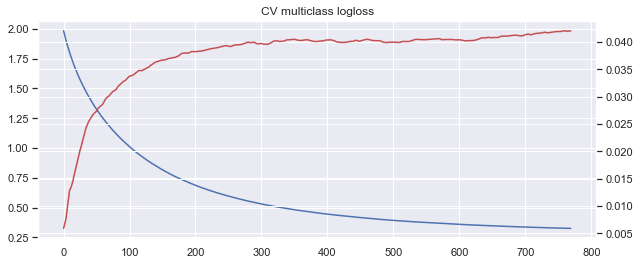

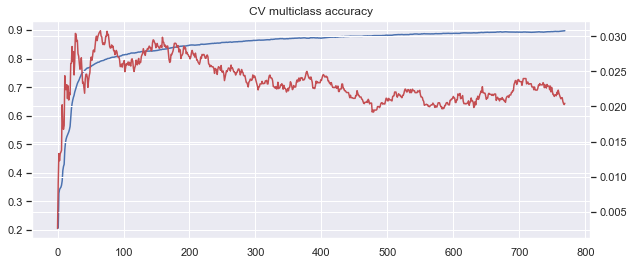

In [ ]:
v1, v2 = eval_hist['multi_logloss-mean'][-1], eval_hist['multi_accuracy-mean'][-1]
print("Validation logloss: {:.4f}, accuracy: {:.4f}".format(v1, v2))
plt.figure(figsize=(10, 4))
plt.title("CV multiclass logloss")
num_rounds = len(eval_hist['multi_logloss-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_logloss-stdv'], ax=ax2, color='r')

plt.figure(figsize=(10, 4))
plt.title("CV multiclass accuracy")
num_rounds = len(eval_hist['multi_accuracy-mean'])
ax = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-mean'])
ax2 = ax.twinx()
p = sns.lineplot(x=range(num_rounds), y=eval_hist['multi_accuracy-stdv'], ax=ax2, color='r')

In [ ]:
importance = pd.DataFrame({'gain': clf.feature_importance(importance_type='gain'),
                           'feature': clf.feature_name()})
importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
ax = sns.barplot(x='gain', y='feature', data=importance)

In [ ]:
sample_submission['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sample_submission.to_csv('Lgb.csv', index=False)

## if you find this Kernel useful then please upvote